In [2]:
import numpy as np
import ase.io
from sympy.utilities.iterables import multiset_permutations
from scipy.spatial import ConvexHull

from VASP_common_utilites import *
from voids_bcc import *

In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [4]:
import matplotlib as mpl
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoLocator

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [6]:
def best_KDE_estimator_multivar(data, kern = 'gaussian', cv_num = 10,r_tolerance=1e-8, ncpus = 8):
    grid = GridSearchCV(KernelDensity(kernel = kern,rtol = r_tolerance), {'bandwidth': np.logspace(-3, 1, 50)}, cv= cv_num,n_jobs = ncpus)
    grid.fit(data)
    return grid.best_estimator_

In [7]:
# initial strucutre
poscar_name = 'POSCAR_HEA_RND.vasp'
# the relaxed structure
contcar_name = 'CONTCAR'
# the size of the SC:
nx = 3
ny = 4
nz = 5

In [8]:
# init the data
Nxyz = np.array([nx,ny,nz])
poscar = ase.io.read(poscar_name)
contcar = ase.io.read(contcar_name)
#
displacements = mk_displacements(Nxyz)
lattice = poscar.get_cell()
init_pos = poscar.get_scaled_positions()
new_positions = contcar.get_scaled_positions()
# 
pos2analyze = new_positions
TetraVoidsDict = {}
void_num = 0
# initialize the objects
for d_idx in range(displacements.shape[0]):
    cell_disp = displacements[d_idx,:]
    TetraVoidsDict[d_idx] = TetraVoid(cell_disp,Nxyz, lattice, init_pos)
    void_num += TetraVoidsDict[d_idx].number_voids
volumes = np.zeros(void_num)
cnt = 0
# identify the volumes in the relaxed structure
for key in TetraVoidsDict.keys():
    try:
        v_d = TetraVoidsDict[key].extract_void_coordinates(pos2analyze)
        for key_v in v_d.keys():
            hull = ConvexHull(v_d[key_v])
            volumes[cnt]=hull.volume
            cnt +=1
    except:
        pass
# due to methods of initialization of the voids, "volumes"
# contains pairs of the same volume (within precision, of course)
# since each void is counted twice, therefore such doublets should
# be removed
non_degenerate_volumes = sparse_array_for_degeneracy(volumes,degeneracy_deg=2)

In [ ]:
np.savetxt('Volumes_ralaxed.dat',non_degenerate_volumes,fmt = '%10.6f')

In [9]:
# identify original volume:
init_volumes = np.zeros(void_num)
cnt = 0
# identify the volumes
for key in TetraVoidsDict.keys():
    try:
        v_d = TetraVoidsDict[key].extract_void_coordinates(init_pos)
        for key_v in v_d.keys():
            hull = ConvexHull(v_d[key_v])
            init_volumes[cnt]=hull.volume
            cnt +=1
    except:
        pass
# due to methods of initialization of the voids, "init_volumes"
# contains pairs of the same volume (within precision, of course)
# since each void is counted twice, therefore such doublets should
# be removed
init_volumes_non_degenerate = sparse_array_for_degeneracy(init_volumes,degeneracy_deg=2)

In [10]:
print ('Volume of the tetrahedral voids is %f, volume of the relaxed cell is %f' % (non_degenerate_volumes.sum(), contcar.get_volume()))
print('Volume of the original cell: %f, volume of the relaxed cell: %f' % (poscar.get_volume(),contcar.get_volume()))

Volume of the tetrahedral voids is 2358.870105, volume of the relaxed cell is 2358.240000
Volume of the original cell: 2358.240000, volume of the relaxed cell: 2358.240000


In [11]:
std = np.std(non_degenerate_volumes)
mean = np.mean(non_degenerate_volumes)
init_vol = np.mean(init_volumes_non_degenerate)
print('Original voids. Mean volume: %f, average: %f, std: %f' % (np.mean(init_volumes_non_degenerate), 
                                                                 np.average(init_volumes_non_degenerate),np.std(init_volumes_non_degenerate)))
print('Voids in the relaxed structure. Mean volume: %f, average: %f, std: %f' % (mean, np.average(non_degenerate_volumes), std))

Original voids. Mean volume: 3.275333, average: 3.275333, std: 0.000000
Voids in the relaxed structure. Mean volume: 3.276208, average: 3.276208, std: 0.368474


In [ ]:
# Volumes of all the tetrahedral voids bein summarized must result 
# in the volume of the cell. As seen above, this is exactly the case.
# Furthermore, the mean and average results must be exactly the same
# for an ideal BCC structure. The standard deviation also should
# be zero in this case since in the ideal structure volumes
# of all the voids are the same.

In [12]:
# make the KDE estimations
kernel = 'gaussian'
estimator = best_KDE_estimator_multivar(non_degenerate_volumes.reshape(-1,1), r_tolerance=1e-5)
dat = np.linspace(min(non_degenerate_volumes)*0,max(non_degenerate_volumes)*1.5,num=200).reshape(-1,1)
vals = np.exp(estimator.score_samples(dat))
vals = vals / max(vals)

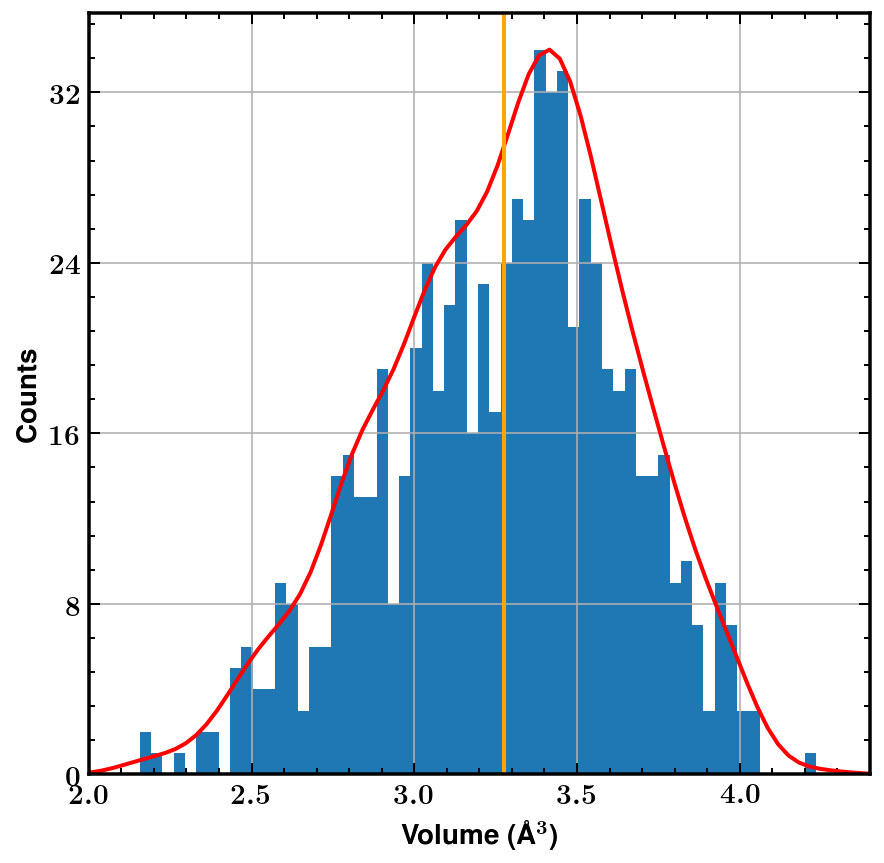

In [14]:
# set general parameters
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)
rc('axes', linewidth=1.75)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

tick_parameters_major = {
            'which': 'major',
            'direction': 'in',
            'width': 1,
            'length': 5.5,
            'labelsize': 14
        }

tick_parameters_minor = {
    'which': 'minor',
    'direction': 'in',
    'width': 1,
    'length': 3,
    'labelsize': 14
}

labels_params = {
            'weight': 'bold',
            'size': 14
        }
legend_params = {'loc': 'center', 'fontsize': 12}

minor_ticks_num_x = 5
minor_ticks_num_y = 5

major_ticks_x = 7
major_ticks_y = 5

fig, ax = plt.subplots(1,1, figsize = (7,7))


n, bins, patches = ax.hist(non_degenerate_volumes,bins=60,density=False)
vals_scaled = vals * max(n)
ax.plot(dat,vals_scaled, lw=2,c= 'r')
ax.set_xlim(2,4.4)
ax.set_xlabel(r'\textbf{Volume (\AA$^{3}$)}', **labels_params)
ax.set_ylabel(r'\textbf{Counts}',**labels_params)
ax.grid()
ax.minorticks_on()
ax.xaxis.set_minor_locator(AutoMinorLocator(minor_ticks_num_x))
ax.yaxis.set_minor_locator(AutoMinorLocator(minor_ticks_num_y))
#ax.xaxis.set_major_locator(MaxNLocator(major_ticks_x))
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params('both', **tick_parameters_major)
ax.tick_params('both', **tick_parameters_minor)
ax.yaxis.set_major_locator(MaxNLocator(major_ticks_y))
ax.axvline(init_vol, lw = 2, color = 'orange')

In [ ]:
fmt = 'pdf'
figname = 'HIST_tetra_voids'  + '.' + fmt
fig.savefig(figname, bbox_inches='tight', format=fmt, dpi=200)